In [1]:
import sys
sys.path.append("..")
from package import TreeOperator

file_dir = "/home/JYChen/EnergyRegression/samples/DoubleElectron_FlatPT-1to500_13p6TeV/"
IdealPath = f"{file_dir}DoubleElectron_ECALIdealIC_PostEE_124X_30032023.root"
RealPath = f"{file_dir}DoubleElectron_ECALRealIC_PostEE_124X_02042023.root"
treename = "egRegTree"

reader = TreeOperator()
reader.set_names(inpath=IdealPath, treename=treename)
Idealdf = reader.get_tree(fmt="pd", debug = True)
reader.set_names(inpath=RealPath, treename=treename)
Realdf = reader.get_tree(fmt="pd", debug = True)

2024-04-14 22:01:11.505717: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-14 22:01:12.572029: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 22:01:12.572107: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 22:01:12.748928: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-14 22:01:13.046554: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import json
import pathlib
import shutil
logdir = pathlib.Path("/home/JYChen/EnergyRegression/log/tfTrainer")/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)
with open("/home/JYChen/EnergyRegression/config/Run3Electron_PostEE.json") as file:
    conf = json.load(file)

In [34]:
# targets
target1 = "{dfname}.mc_energy/{dfname}.sc_rawEnergy"
target2 = "{dfname}.mc_energy/(({dfname}.sc_rawEnergy+{dfname}.sc_rawESEnergy)*{dfname}.regIdealMean)"
target3 = "({dfname}.mc_energy * ({dfname}.ele_trkPModeErr*{dfname}.ele_trkPModeErr + ({dfname}.sc_rawEnergy+{dfname}.sc_rawESEnergy)*({dfname}.sc_rawEnergy+{dfname}.sc_rawESEnergy)*{dfname}.regRealSigma*{dfname}.regRealSigma)  / ( ({dfname}.sc_rawEnergy+{dfname}.sc_rawESEnergy)*regIdealMean*{dfname}.ele_trkPModeErr*{dfname}.ele_trkPModeErr + {dfname}.ele_trkPMode*({dfname}.sc_rawEnergy+{dfname}.sc_rawESEnergy)*({dfname}.sc_rawEnergy+{dfname}.sc_rawESEnergy)*{dfname}.regRealSigma*{dfname}.regRealSigma ))"

In [ ]:
# create target columns 
Idealdf["target1"] = eval(target1.format(dfname="Idealdf"))

In [3]:
def setup_dataset(df, vars, target):
    import pandas as pd
    dataset = pd.DataFrame()
    table = {}
    dataset["isEB"] = df.sc_isEB
    for idx, var in enumerate(vars):
        dataset[f"var{idx}"] = eval(var.format(dfname = "df"))
        table[f"var{idx}"] = var.format(dfname = "").replace(".", "")
    dataset["target"] = eval(target.format(dfname = "df"))
    dataset.pop("isEB")
    return (table, dataset)

In [4]:
var_eb, dataset_eb = setup_dataset(Idealdf, conf["var_eb"], conf["target1"])
var_ee, dataset_ee = setup_dataset(Idealdf, conf["var_ee"], conf["target1"])

In [5]:
import time
train_dataset = dataset_eb.sample(frac=0.8, random_state=int(time.time()))
test_dataset = dataset_eb.drop(train_dataset.index)

In [81]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(1, activation='relu'),
      # layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])
  # mse = tf.keras.losses.MeanSquaredError()  
  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.0001))
  return model


In [7]:
# N_VALIDATION = int(1e3)
N_TRAIN = train_dataset.shape[0] * 0.5
# BUFFER_SIZE = int(1e4)
BATCH_SIZE = 50
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
FEATURES = 32

In [50]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*100,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [40]:
def get_callbacks(name):
    import tensorflow_docs as tfdocs
    import tensorflow_docs.modeling as tfdocsmd
    return [
        tfdocsmd.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name),
    ]

In [8]:
# setup the dataset and the model
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('target')
test_labels = test_features.pop('target')

# normalizer = tf.keras.layers.Normalization(axis=-1, )
# normalizer = tf.keras.layers.experimental.preprocessing.Normalization(axis=None)
normalizer = layers.Normalization(input_shape=[FEATURES,], axis=None)
normalizer.adapt(np.array(train_features))

2024-04-14 22:02:42.417133: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2024-04-14 22:02:42.417214: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: chip02.cms.phy.ncu.edu.tw
2024-04-14 22:02:42.417229: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: chip02.cms.phy.ncu.edu.tw
2024-04-14 22:02:42.417452: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 550.54.15
2024-04-14 22:02:42.417508: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 510.47.3
2024-04-14 22:02:42.417520: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 510.47.3 does not match DSO version 550.54.15 -- cannot find working devices in this co

In [32]:
layer = keras.layers.Normalization(axis=-1, invert=True)
layer.adapt(train_features)
layer(train_features)

<tf.Tensor: shape=(8000, 32), dtype=float32, numpy=
array([[ 1.5366364e+05,  1.1230631e-02,  1.7661532e-02, ...,
         2.3825015e-01, -5.9446682e+01,  7.9380394e+01],
       [ 3.2249777e+04,  1.1250802e-02,  1.8343484e-02, ...,
         6.6426301e-01,  5.3375013e-02,  6.0668232e+01],
       [ 1.7929755e+06,  1.1309475e-02,  1.7721934e-02, ...,
         2.3825015e-01,  5.3375013e-02,  4.5317512e+00],
       ...,
       [ 5.7433941e+04,  1.1227966e-02,  1.7566567e-02, ...,
         6.6426301e-01,  1.4928390e+01,  1.0769138e+01],
       [ 3.7186366e+05,  1.1246847e-02,  1.7905336e-02, ...,
         6.6426301e-01,  2.2365896e+01,  8.5617783e+01],
       [ 1.2011371e+06,  1.1309082e-02,  1.7681159e-02, ...,
         2.3825015e-01,  5.3375013e-02,  4.5317512e+00]], dtype=float32)>

In [59]:
def compile_and_fit(model, name, optimizer=None, max_epochs=100):
    if optimizer is None:
        optimizer = get_optimizer()
    # model.compile(optimizer=optimizer,
    #                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    #                 metrics=[
    #                 tf.keras.metrics.BinaryCrossentropy(
    #                     from_logits=True, name='binary_crossentropy'),
    #                 'accuracy'])
    model.compile(loss='mean_absolute_error',
                    # optimizer=optimizer)
                    optimizer=tf.keras.optimizers.Adam(0.001))
    model.summary()

    history = model.fit(
        train_features,
        train_labels,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_split=0.5,
        callbacks=get_callbacks(name),
        verbose=0)
    return history

In [82]:
dnn_model = build_and_compile_model(layer)
dnn_model.summary()
# model.fit(train_features, train_labels, validation_split=0.5, verbose=1, epochs=10)


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normaliza  (None, 32)                65        
 tion)                                                           
                                                                 
 dense_44 (Dense)            (None, 1)                 33        
                                                                 
 dense_45 (Dense)            (None, 1)                 2         
                                                                 
Total params: 100 (404.00 Byte)
Trainable params: 35 (140.00 Byte)
Non-trainable params: 65 (264.00 Byte)
_________________________________________________________________


In [84]:
history = dnn_model.fit(
    layer(train_features),
    train_labels,
    validation_split=0.6,
    verbose=1, epochs=100)

Epoch 1/100
100/100 [==============================] - 2s 11ms/step - loss: inf - val_loss: inf
Epoch 2/100
100/100 [==============================] - 1s 6ms/step - loss: inf - val_loss: inf
Epoch 3/100
100/100 [==============================] - 1s 6ms/step - loss: inf - val_loss: inf
Epoch 4/100
100/100 [==============================] - 1s 8ms/step - loss: inf - val_loss: inf
Epoch 5/100
100/100 [==============================] - 1s 8ms/step - loss: inf - val_loss: inf
Epoch 6/100
100/100 [==============================] - 1s 8ms/step - loss: inf - val_loss: inf
Epoch 7/100
100/100 [==============================] - 1s 8ms/step - loss: inf - val_loss: inf
Epoch 8/100
100/100 [==============================] - 1s 6ms/step - loss: inf - val_loss: inf
Epoch 9/100
100/100 [==============================] - 1s 9ms/step - loss: inf - val_loss: inf
Epoch 10/100
100/100 [==============================] - 1s 6ms/step - loss: inf - val_loss: inf
Epoch 11/100
100/100 [==========================

In [64]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [68]:
train_labels

entry
115     1.024233
194     1.386863
4523    1.041889
1827    0.996152
1845    1.026985
          ...   
5940    1.031675
3063    1.049644
6686    1.032314
8112    1.048748
9074    1.028643
Name: target, Length: 8000, dtype: float64

Text(0.5, 0, 'Epochs [Log Scale]')

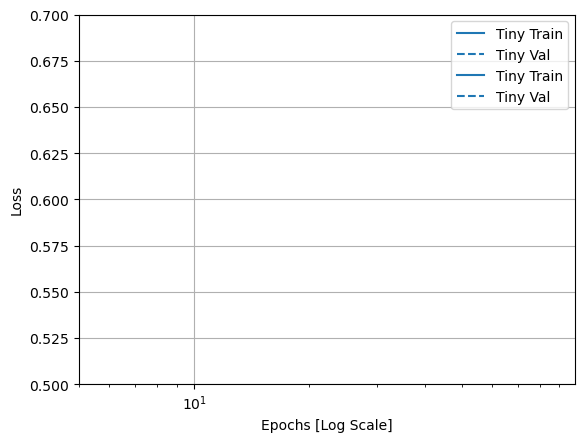

In [101]:
import tensorflow_docs.plots as tfdocsplt
import matplotlib.pyplot as plt
plotter = tfdocsplt.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [25]:
def plot_loss(history):
    import matplotlib.pyplot as plt
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

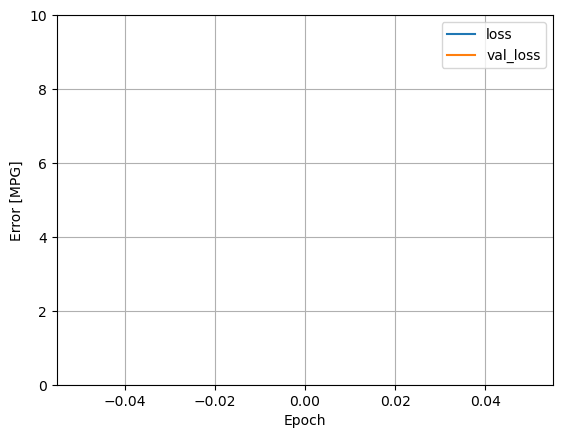

In [48]:
plot_loss(history)